In [1]:
from classes import *
from utils import *
import math

from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional
from collections import defaultdict
import linearize_io_helper as io_helper

%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# make the font of the plots bigger
plt.rcParams.update({'font.size': 14})

<IPython.core.display.Javascript object>

In [18]:
def linearize_io(spec: List[Call], verbose=False):
    sort_by_var: DefaultDict[int, List[Call]] = defaultdict(list)
    false_cases: List[CallCAS] = []
    true_cases: List[CallCAS] = []

    io_helper.populate_call_bins(spec, sort_by_var, true_cases, false_cases)

    writes = io_helper.basic_io_checks(sort_by_var)
    if writes is None:
        return False

    if not io_helper.basic_true_cas_checks(true_cases):
        return False

    io_helper.topological_true_cas_sort(true_cases)

    true_cas_var_groups: List[List[int]] = []
    for true_cas in true_cases:
        for group in true_cas_var_groups:
            if true_cas.compare == group[-1]:
                group.append(true_cas.swap)
                break
        else:
            true_cas_var_groups.append([true_cas.compare, true_cas.swap])

    true_cas_call_groups: List[List[Call]] = []
    for group in true_cas_var_groups:
        all_group_ops: List[Call] = []
        for var in group:
            all_group_ops.extend(sort_by_var[var])
        all_group_ops = list(dict.fromkeys(all_group_ops))
        true_cas_call_groups.append(all_group_ops)

    # intra-group check
    for group_i in range(len(true_cas_var_groups)):
        intra_group_bins = defaultdict(list)
        io_helper.populate_call_bins(true_cas_call_groups[group_i], intra_group_bins, [], [])
        intra_group_intervals = io_helper.make_intervals(intra_group_bins)
        order = true_cas_var_groups[group_i]
        if io_helper.true_cas_intra_group_check(intra_group_intervals, order) is not True:
            return False

    # inter-group check
    for var_group in true_cas_var_groups:
        var = var_group[0]
        for other_var in var_group[1:]:
            sort_by_var[var].extend(sort_by_var[other_var])
            del sort_by_var[other_var]

    intervals: Dict[int, I] = io_helper.make_intervals(sort_by_var)

    if not io_helper.io_check(intervals):
        return False

    blocks = io_helper.make_blocks(intervals)

    false_cas_var_resolver: Dict[CallCAS, Set[int]] = {}
    false_cases.sort(key=lambda x: x.end)
    for false_cas in false_cases:
        available_writes: List[int] = []
        block_i = 0

        while block_i < len(blocks):
            block = blocks[block_i]

            if min((min(c.end for c in sort_by_var[var]) for var in block)) < false_cas.start:
                available_writes.clear()

            writes_in_block = {var for var in block if writes[var].start < false_cas.end}
            # assert len(writes_in_block) == len(block)

            available_writes.extend(writes_in_block)

            if len(writes_in_block) == 0:
                break

            line = 0
            for var in writes_in_block:
                interval = intervals[var]
                if interval.reversed:
                    line = max(line, interval.start)
                else:
                    line = max(line, interval.end)

            if false_cas.end > line:
                block_i += 1
            else:
                break

        # if the false cas is fully contained in a forward interval then the only available write is of that interval
        for var in available_writes.copy():
            interval = intervals[var]
            if interval.reversed:
                continue
            if I(false_cas.start, false_cas.end).isContainedIn(interval):
                available_writes = [var]
                break

        false_cas_var_resolver[false_cas] = set(available_writes)

    for false_cas in false_cases:
        false_cas_var_resolver[false_cas].discard(false_cas.compare)

    visited: Dict[int, I] = {}
    for false_cas in false_cases:
        if false_cas.compare not in visited and false_cas.compare in writes:
            if false_cas.start > writes[false_cas.compare].end:
                visited[false_cas.compare] = I(false_cas.end, math.inf)

    for false_cas in false_cases:
        for var in false_cas_var_resolver[false_cas].copy():
            if var in visited:
                if I(false_cas.start, false_cas.end).isContainedIn(visited[var]):
                    false_cas_var_resolver[false_cas].remove(var)

    locked_mem: Dict[int, I] = {}
    for false_cas in false_cases:
        if len(false_cas_var_resolver[false_cas]) == 1:
            v = next(iter(false_cas_var_resolver[false_cas]))
            i1, i2 = min(c.end for c in sort_by_var[v]), false_cas.start
            rev = i1 > i2
            if rev:
                i1, i2 = i2, i1
            if v in locked_mem:
                locked_mem[v] = I(min(locked_mem[v].start, i1), max(locked_mem[v].end, i2), rev)
            else:
                locked_mem[v] = I(i1, i2, rev)

    if verbose:
        print(blocks)
        print({f"{k} ({round(k.start, 2)} - {round(k.end,2)})": v for k, v in false_cas_var_resolver.items()})
        print(locked_mem)

    if not io_helper.io_check(locked_mem):
        return False

    for false_cas in false_cases:
        if len(false_cas_var_resolver[false_cas]) == 0:
            return False

    return True


<IPython.core.display.Javascript object>

In [4]:
# generate_tests(filename="try3.pkl",
#                success_percentage=0.1,
#                total = 1_000_000,
#                no_threads= 4,
#                no_operations=9,
#                no_variables=4,
#                min_ops=7,
#                min_cas=1,
#                min_read=1)

<IPython.core.display.Javascript object>

In [15]:
test = load_test("readFirst1.pkl")

<IPython.core.display.Javascript object>

In [6]:
# test = [t for t in test if isIntervals_strictly_ordered(t[0])]
# test = [t for t in test if isRead_before_cas(t[0])]

<IPython.core.display.Javascript object>

In [7]:
def run_test(testsample: List[Tuple[List[Call], bool]]):
    wrong_test_no = []
    for i in tqdm.tqdm(range(len(testsample))):
        testcase, res = copy.deepcopy(testsample[i])
        try:
            sol = linearize_io(testcase)
            s2 = (sol is True)
            if res ^ s2:
                wrong_test_no.append(i)

        except AssertionError as e:
            raise e

    print(f"Tests failed: {len(wrong_test_no)}")
    if len(wrong_test_no) == 0:
        print("All tests passed")
    else:
        print(f"First failed: {str(wrong_test_no[:10]).strip('[]')} ...")
    
    return wrong_test_no

<IPython.core.display.Javascript object>

In [16]:
wrong_test_no = run_test(test)

100%|██████████| 84449/84449 [00:11<00:00, 7157.45it/s]

Tests failed: 2
First failed: 27078, 60450 ...


<IPython.core.display.Javascript object>

In [ ]:
# total = 0
# count = 0
# no = []
# for failed_test in wrong_test_no:
#     total += 1
#     spec, res = test[failed_test]
#     sort_by_var = defaultdict(list)
#     io_helper.populate_call_bins(spec, sort_by_var, [], [])
#     blocks = io_helper.make_blocks(io_helper.make_intervals(sort_by_var))
#     # if it contains a block with two elements
#     if all(len(block) in (1, 3) for block in blocks) and any(len(block) == 3 for block in blocks):
#         count += 1
#         no.append(failed_test)

# print(count/total)
# critical_cases = [757, 1644, 2091, 2596, 2767, 4460, 5759, 7172, 7964, 10536]

Testcase 27078 is True
[[2], [3, 1]]
{'!2 (16.19 - 17.21)': {3}, '!3 (26.68 - 30.13)': {1}}
{3: 13.229560735040208 - 16.191264359066594, 1: 11.5372168281693 - 26.675999436549688}
False


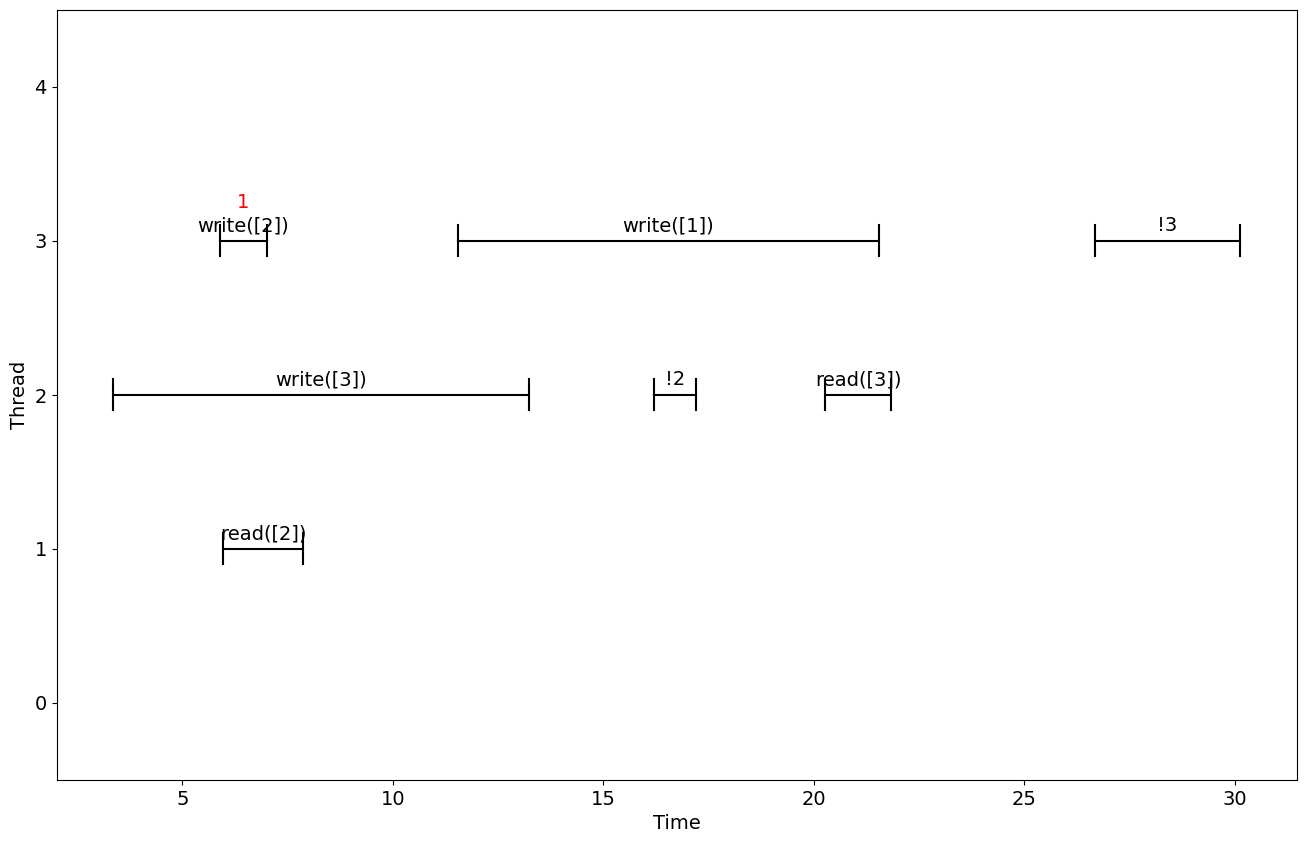

<IPython.core.display.Javascript object>

In [17]:
i = 27078
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
print(linearize_io(testcase, verbose=True))
# sol = linearize_generic(testcase, StateIO())
# visualize_history(testcase)
visualize_history(testcase)

In [ ]:
testcase, res = copy.deepcopy(test[i])
print(f"Testcase {i} is {res}")
visualize_history(testcase)

In [ ]:
for wrong_test in wrong_test_no:
    testcase, res = copy.deepcopy(test[wrong_test])
    print(f"Testcase {wrong_test} is {res}")
    print(linearize_io(testcase, verbose=True))
    visualize_history(testcase)